In [ ]:
!pip3 uninstall torch torchvision --yes

In [ ]:
!pip3 install torch==1.11.0 torchvision==0.12

In [46]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

import time
import os
import copy
import random

import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0+cu102
Torchvision Version:  0.12.0+cu102


In [47]:
train = pd.read_csv(r'/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv(r'/kaggle/input/digit-recognizer/test.csv')

In [48]:
y_train = train['label']
X_train = train.drop('label', axis=1)

In [49]:
X_train /= 255.
test /= 255.

In [50]:
X_train.shape

(42000, 784)

In [51]:
y_train.shape

(42000,)

In [52]:
dataset_sizes = {'train': len(X_train), 'test':len(test)}

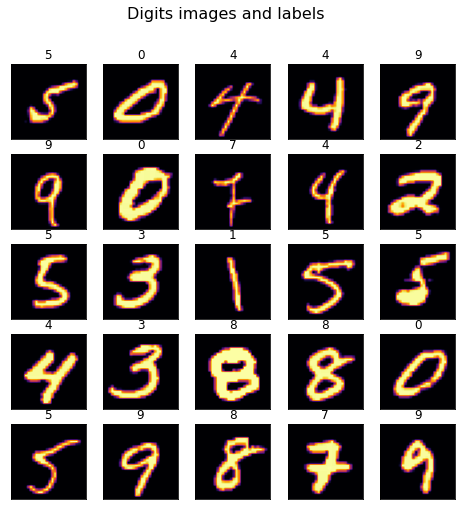

In [53]:
fig, ax = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Digits images and labels', fontsize=16)
ax = ax.ravel()
for i in range(25):
    sample_n = random.randint(0, X_train.shape[0])
    ax[i].imshow(np.array(X_train.iloc[sample_n]).reshape(28, 28), cmap='inferno')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(y_train[sample_n], fontsize = 12)

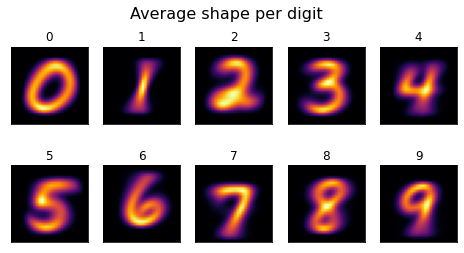

In [54]:
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle('Average shape per digit', fontsize=16)

ax = ax.ravel()

for i in range(10):
    ax[i].imshow(np.array(train[train['label'] == i].drop('label', axis=1).mean()).reshape(28, 28), cmap='inferno')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(i, fontsize = 12)

In [55]:
X_train_array = np.array(X_train)
X_train_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
test_array = np.array(test)
test_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
X_train_array = X_train_array.reshape(42000, 1, 28, 28)
test_array = test_array.reshape(-1, 1, 28, 28)

In [58]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

In [59]:
train_data = []
for i in range(len(X_train_array)):
   train_data.append([X_train_array[i], y_train[i]])
dataloaders = {'train': torch.utils.data.DataLoader(train_data, batch_size=64,
                                             shuffle=True, num_workers=4)
              ,'test':  torch.utils.data.DataLoader(test_array, batch_size=20,
                                             shuffle=False, num_workers=4)}

In [60]:
# training_loader = dataloaders['train']
# dataiter = iter(training_loader)
# images, labels = dataiter.next()
# images = images.float()

In [66]:
# model_ft = models.VisionTransformer(image_size=28, patch_size=2,  num_layers=12, num_heads=12, 
#                                     hidden_dim=768, mlp_dim=3072, dropout = 0.1)

# model_ft = models.VisionTransformer(image_size=28, patch_size=4,  num_layers=12, num_heads=12, 
#                                     hidden_dim=768, mlp_dim=3072)# dropout = 0.1)
model_ft = models.VisionTransformer(image_size=28, patch_size=7,  num_layers=6, num_heads=8, 
                                    hidden_dim=320, mlp_dim=768, dropout = 0.2)

num_ftrs = model_ft.heads.head.in_features
model_ft.heads.head = nn.Linear(num_ftrs, 10)

# model_ft.conv_proj = torch.nn.Conv2d(1, 768, kernel_size=(4, 4), stride=(4, 4))
# model_ft.conv_proj = torch.nn.Conv2d(1, 768, kernel_size=(2, 2), stride=(2, 2))
model_ft.conv_proj = torch.nn.Conv2d(1, 320, kernel_size=(7, 7), stride=(7, 7))

In [67]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    model.to(device)
    since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_num, [inputs, labels] in enumerate(tqdm.tqdm(dataloaders[phase])):
                inputs = inputs.float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    torch.save(model.state_dict(), 'model.pt')

    return model

In [68]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0003)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer_ft, T_0=5, T_mult=1, eta_min=0, last_epoch=-1)

In [69]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


100%|██████████| 657/657 [00:15<00:00, 42.33it/s]


train Loss: 0.6807 Acc: 0.7725

Epoch 1/14
----------


100%|██████████| 657/657 [00:15<00:00, 41.87it/s]


train Loss: 0.2174 Acc: 0.9324

Epoch 2/14
----------


100%|██████████| 657/657 [00:15<00:00, 41.63it/s]


train Loss: 0.1468 Acc: 0.9536

Epoch 3/14
----------


100%|██████████| 657/657 [00:15<00:00, 42.32it/s]


train Loss: 0.0999 Acc: 0.9681

Epoch 4/14
----------


100%|██████████| 657/657 [00:15<00:00, 42.11it/s]


train Loss: 0.0735 Acc: 0.9766

Epoch 5/14
----------


100%|██████████| 657/657 [00:15<00:00, 42.23it/s]


train Loss: 0.1499 Acc: 0.9528

Epoch 6/14
----------


100%|██████████| 657/657 [00:15<00:00, 42.08it/s]


train Loss: 0.1089 Acc: 0.9652

Epoch 7/14
----------


100%|██████████| 657/657 [00:15<00:00, 42.53it/s]


train Loss: 0.0812 Acc: 0.9740

Epoch 8/14
----------


100%|██████████| 657/657 [00:15<00:00, 42.10it/s]


train Loss: 0.0550 Acc: 0.9824

Epoch 9/14
----------


100%|██████████| 657/657 [00:15<00:00, 42.48it/s]


train Loss: 0.0349 Acc: 0.9891

Epoch 10/14
----------


100%|██████████| 657/657 [00:16<00:00, 40.67it/s]


train Loss: 0.1051 Acc: 0.9656

Epoch 11/14
----------


100%|██████████| 657/657 [00:15<00:00, 43.64it/s]


train Loss: 0.0803 Acc: 0.9744

Epoch 12/14
----------


100%|██████████| 657/657 [00:15<00:00, 42.07it/s]


train Loss: 0.0532 Acc: 0.9831

Epoch 13/14
----------


100%|██████████| 657/657 [00:15<00:00, 43.48it/s]


train Loss: 0.0352 Acc: 0.9883

Epoch 14/14
----------


100%|██████████| 657/657 [00:15<00:00, 41.75it/s]


train Loss: 0.0234 Acc: 0.9926

Training complete in 3m 54s


In [75]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


100%|██████████| 657/657 [00:15<00:00, 43.56it/s]


train Loss: 0.0855 Acc: 0.9729

Epoch 1/4
----------


100%|██████████| 657/657 [00:15<00:00, 42.37it/s]


train Loss: 0.0613 Acc: 0.9791

Epoch 2/4
----------


100%|██████████| 657/657 [00:15<00:00, 43.27it/s]


train Loss: 0.0445 Acc: 0.9849

Epoch 3/4
----------


100%|██████████| 657/657 [00:15<00:00, 42.73it/s]


train Loss: 0.0274 Acc: 0.9909

Epoch 4/4
----------


100%|██████████| 657/657 [00:15<00:00, 43.08it/s]


train Loss: 0.0181 Acc: 0.9941

Training complete in 1m 16s


In [81]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


100%|██████████| 657/657 [00:15<00:00, 42.04it/s]


train Loss: 0.0705 Acc: 0.9766

Epoch 1/4
----------


100%|██████████| 657/657 [00:14<00:00, 43.81it/s]


train Loss: 0.0533 Acc: 0.9821

Epoch 2/4
----------


100%|██████████| 657/657 [00:15<00:00, 42.04it/s]


train Loss: 0.0361 Acc: 0.9880

Epoch 3/4
----------


100%|██████████| 657/657 [00:15<00:00, 42.07it/s]


train Loss: 0.0202 Acc: 0.9934

Epoch 4/4
----------


100%|██████████| 657/657 [00:15<00:00, 42.77it/s]


train Loss: 0.0141 Acc: 0.9957

Training complete in 1m 17s


In [87]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


100%|██████████| 657/657 [00:15<00:00, 42.23it/s]


train Loss: 0.0634 Acc: 0.9794

Epoch 1/4
----------


100%|██████████| 657/657 [00:15<00:00, 42.57it/s]


train Loss: 0.0470 Acc: 0.9840

Epoch 2/4
----------


100%|██████████| 657/657 [00:15<00:00, 43.12it/s]


train Loss: 0.0323 Acc: 0.9892

Epoch 3/4
----------


100%|██████████| 657/657 [00:15<00:00, 42.36it/s]


train Loss: 0.0181 Acc: 0.9941

Epoch 4/4
----------


100%|██████████| 657/657 [00:15<00:00, 43.41it/s]

train Loss: 0.0106 Acc: 0.9969

Training complete in 1m 17s


In [88]:
def prediction(model, data_loader):
    model.to(device)
    model.eval()
    test_pred = torch.LongTensor()
    with torch.no_grad():        
        for i, data in enumerate(tqdm.tqdm(data_loader)):
            data = data.float()
            data = data.to(device)

            output = model(data)

            _,pred = torch.max(output,1) 
            test_pred = torch.cat((test_pred,pred.cpu()),dim=0)
          
        
    return test_pred

In [89]:
test_loader = dataloaders['test']
test_pred = prediction(model_ft, test_loader)
predictions = test_pred.numpy()

100%|██████████| 1400/1400 [00:08<00:00, 162.71it/s]


In [90]:
submission = pd.read_csv(r'/kaggle/input/digit-recognizer/sample_submission.csv')

In [91]:
submission['Label'] = predictions

In [92]:
submission.to_csv('/kaggle/working/t_submission.csv',index = False)

In [ ]:
test.shape